## Import Library

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

## Read Data

In [2]:
# Membaca data training dari file CSV untuk saham MU dan Google
mu_data = pd.read_csv('Data/MANU.csv')
google_data = pd.read_csv('Data/GOOGL.csv')
# google_data = pd.read_csv('Data/EDR.csv')

## Preprocessing

In [3]:
mu_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
google_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
mu_data.duplicated().sum()

0

In [6]:
google_data.duplicated().sum()

0

In [7]:
def atribut_tidak_lengkap(data):
    # Daftar kolom yang akan dicek untuk nilai kosong
    kolom_cek = ['Open', 'High', 'Low', 'Close', 'Adj Close']
    
    # Mengecek apakah terdapat nilai kosong di kolom-kolom yang disebutkan
    if data[kolom_cek].isnull().values.any():
        # Cetak nilai-nilai yang kosong
        print("Nilai yang kosong ada pada kolom :")
        print(data[data[kolom_cek].isnull().any(axis=1)])
        
        # Hapus baris yang memiliki nilai kosong di kolom yang disebutkan
        data.dropna(subset=kolom_cek, inplace=True)
        print("Nilai kosong telah dihapus!")
    else:
        print("Nilai yang kosong tidak ditemukan!")

    return data


In [8]:
google_data = atribut_tidak_lengkap(google_data)

Nilai yang kosong tidak ditemukan!


In [9]:
mu_data = atribut_tidak_lengkap(mu_data)

Nilai yang kosong tidak ditemukan!


## Ekstraksi Feature

In [10]:
# Ekstarksi fitur menggunakan RSI
# untuk menentukan label pada kelas maka melakukan perbandingan dari hasil RSI dengen ketentuan:
# 1. Jika > 70 maka Overbought (Naik === Jual) maka dilabelkan menajdi 1
# 2. Jika < 30 maka Oversold (Tutun === Beli) maka dilabelkan menajdi -1
# 3. Jika 30 - 70 maka hold (Tahan) maka dilabelkan menajdi 0

In [11]:
def calculate_RSI(data, period_RSI=14):
    differencePrice = data['Close'].diff()
    differencePriceValues = differencePrice.values

    current_average_positive = 0
    current_average_negative = 0
    price_index = 0
    RSI = []

    for difference in differencePriceValues[1:]:
        if difference > 0:
            positive_difference = difference
            negative_difference = 0                
        elif difference < 0:
            negative_difference = np.abs(difference)
            positive_difference = 0
        else:
            positive_difference = 0
            negative_difference = 0

        if price_index < period_RSI:
            current_average_positive += (1/period_RSI) * positive_difference
            current_average_negative += (1/period_RSI) * negative_difference

            if price_index == (period_RSI - 1):
                if current_average_negative != 0:
                    RSI.append(100 - 100 / (1 + (current_average_positive / current_average_negative)))           
                else:
                    RSI.append(100)
        else:
            current_average_positive = ((period_RSI - 1) * current_average_positive + positive_difference) / period_RSI
            current_average_negative = ((period_RSI - 1) * current_average_negative + negative_difference) / period_RSI

            if current_average_negative != 0:
                RSI.append(100 - 100 / (1 + (current_average_positive / current_average_negative)))   
            else:
                RSI.append(100)

        price_index += 1

    return pd.Series(RSI, index=data.index[period_RSI:])

In [12]:
def plot_RSI(RSI_series):
    plt.figure(figsize=(10, 6))
    plt.plot(RSI_series, label='RSI', color='b')
    plt.axhline(y=30, color='r', linestyle='--', label='Oversold (30)')
    plt.axhline(y=70, color='g', linestyle='--', label='Overbought (70)')
    plt.title('Relative Strength Index (RSI)')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
def RSI_target(data):
    
    data['Target'] = np.where(data['RSI'] > 70, 1, np.where(data['RSI'] < 30, -1, 0))
    return data


##### Menemukan Nilai RSI Google

In [14]:
# Menghitung nilai RSI pada data google
RSI_series_Google = calculate_RSI(google_data)

In [15]:
google_data['RSI'] = RSI_series_Google

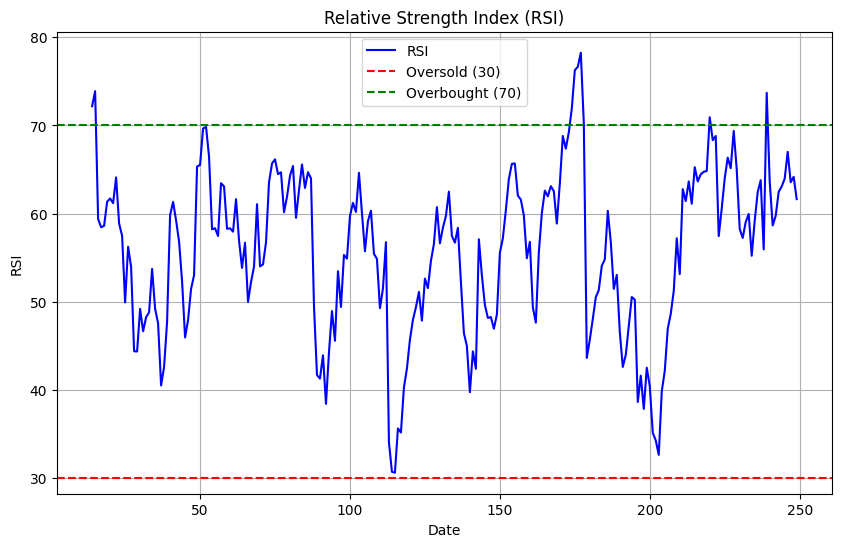

In [16]:
# Menampilkan grafik dari hasil perhitungan RSI pada data google
plot_RSI(google_data['RSI'])

In [17]:
# Menghapus nilai yang kosong pada data google
google_data = google_data.dropna()

##### Menentukan label/target pada data google

In [18]:
# Menentukan label pada data google
google_data = RSI_target(google_data)

In [19]:
google_data[['Close', 'RSI', 'Target']].head(10)

,Close,RSI,Target
14,126.010002,72.175539,1
15,127.309998,73.882556,1
16,122.500000,59.369413,0
17,122.139999,58.444068,0
18,122.230003,58.617727,0
19,123.639999,61.343139,0
20,123.830002,61.709105,0
21,123.669998,61.183807,0
22,125.089996,64.104202,0
23,123.529999,58.864542,0


##### Menemukan nilai RSI MU

In [20]:
# Menghitung nilai RSI pada data MU
RSI_series_MU = RSI_series_Google = calculate_RSI(mu_data)

In [21]:
mu_data['RSI'] = RSI_series_MU

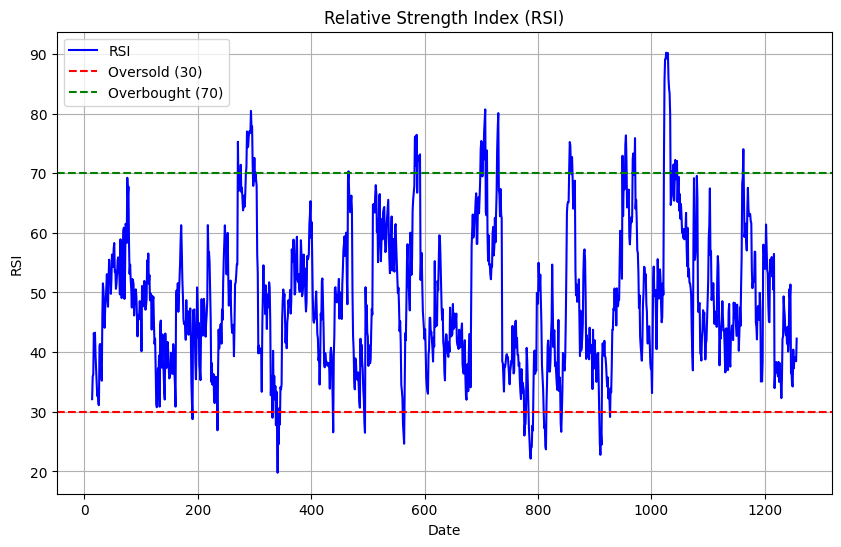

In [22]:
# Menampilkan grafik dari hasil perhitungan RSI pada data MU
plot_RSI(mu_data['RSI'])

In [23]:
# Menghapus nilai yang kosong pada data MU
mu_data = mu_data.dropna()

##### Menentukan label/target pada data MU

In [24]:
# Menentukan label pada data MU
mu_data = RSI_target(mu_data)

In [25]:
mu_data[['Close', 'RSI', 'Target']].head(10)

,Close,RSI,Target
14,18.190001,32.119622,0
15,18.610001,35.890401,0
16,18.650000,36.253585,0
17,19.450001,43.186013,0
18,19.250000,41.957539,0
19,19.400000,43.261147,0
20,18.799999,39.444891,0
21,18.400000,37.095516,0
22,17.980000,34.754785,0
23,17.580000,32.642243,0


In [26]:
google_data['Target'].value_counts()

Target
0    227
1      9
Name: count, dtype: int64

In [27]:
mu_data['Target'].value_counts()

Target
 0    1135
 1      70
-1      38
Name: count, dtype: int64

#### Normalisasi data

In [28]:
def normalize_columns(data, columns_to_normalize, columns_to_leave):
    # Menginisialisasi Min-Max Scaler
    scaler = MinMaxScaler()

    # Salin DataFrame asli jika diperlukan
    df_normalized = data.copy()

    # Lakukan normalisasi pada kolom-kolom yang dipilih
    df_normalized[columns_to_normalize] = scaler.fit_transform(df_normalized[columns_to_normalize])

    return df_normalized


In [29]:
# Menentukan atribut yang akan dinormalisasikan
columns_to_normalize = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI']
columns_to_leave = ['Target']

##### Normalisasi data Google

In [30]:
# Melakukan normalisasi nilai pada data google
df_normalized_google = normalize_columns(google_data, columns_to_normalize, columns_to_leave)
df_normalized_google.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,Target
14,2023-06-05,0.132920,0.170526,0.156354,0.172252,0.172252,0.275444,0.872573,1
15,2023-06-06,0.167355,0.185614,0.184346,0.195676,0.195676,0.196571,0.908397,1
16,2023-06-07,0.183884,0.198772,0.124678,0.109009,0.109009,0.557044,0.603827,0
17,2023-06-08,0.102273,0.096842,0.108471,0.102523,0.102523,0.234857,0.584408,0
18,2023-06-09,0.102617,0.106140,0.120810,0.104144,0.104144,0.156547,0.588052,0
19,2023-06-12,0.111915,0.111228,0.116206,0.129550,0.129550,0.219787,0.645247,0
20,2023-06-13,0.149621,0.130702,0.144199,0.132973,0.132973,0.135891,0.652927,0
21,2023-06-14,0.117252,0.111228,0.112339,0.130090,0.130090,0.251601,0.641903,0
22,2023-06-15,0.117941,0.135965,0.129834,0.155676,0.155676,0.316373,0.703190,0
23,2023-06-16,0.165978,0.147368,0.146041,0.127568,0.127568,0.459274,0.593232,0


##### Normalisasi data MU

In [31]:
# Melakukan normalisasi nilai pada data MU
df_normalized_mu = normalize_columns(mu_data, columns_to_normalize, columns_to_leave)
df_normalized_mu.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,Target
14,2018-11-20,0.571429,0.585731,0.494548,0.470300,0.421603,0.004616,0.175147,0
15,2018-11-21,0.477603,0.513189,0.510584,0.496020,0.446198,0.003747,0.228707,0
16,2018-11-23,0.500605,0.487410,0.512508,0.498469,0.448540,0.000977,0.233866,0
17,2018-11-26,0.509685,0.541367,0.542014,0.547459,0.495388,0.002555,0.332333,0
18,2018-11-27,0.521186,0.535971,0.556767,0.535211,0.483676,0.001011,0.314884,0
19,2018-11-28,0.539952,0.541367,0.565747,0.544397,0.492460,0.002271,0.333400,0
20,2018-11-29,0.530872,0.534173,0.538165,0.507655,0.462455,0.000537,0.279194,0
21,2018-11-30,0.481840,0.475420,0.495189,0.483160,0.438922,0.001987,0.245824,0
22,2018-12-03,0.494552,0.492206,0.471456,0.457440,0.414212,0.003463,0.212577,0
23,2018-12-04,0.461259,0.470624,0.454779,0.432945,0.390679,0.010523,0.182571,0


## Modeling

#### Pembagian Data

In [32]:
features = ['Open', 'Low', 'High', 'Close', 'Adj Close', 'Volume', 'RSI']

In [33]:
# Memisahkan fitur dan target untuk data training saham MU dan Google
X_mu = df_normalized_mu[features]
y_mu = df_normalized_mu['Target']

X_google = df_normalized_google[features]
y_google = df_normalized_google['Target']

In [34]:
# Pembagian data traning dan testing
X_mu_train, X_mu_test, y_mu_train, y_mu_test = train_test_split(X_mu, y_mu, test_size=0.2, random_state=0)

#### Hyperparameter tuning menggunakan GridSearch

In [35]:
svm = SVC(random_state=0)

In [36]:
parameters = {
    'kernel' : ['rbf', 'poly'],
    'C' : [0.1, 1, 10],
    # 'gamma' : ['scale', 1, 0.1, 0.01, 0.001]
}

##### Menggunakan K-fold = 3

In [37]:
grid_search_k3 = GridSearchCV(estimator=svm, param_grid=parameters, cv=3, n_jobs=6, scoring='accuracy', verbose=1)

In [38]:
grid_search_k3.fit(X_mu_train, y_mu_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=SVC(random_state=0), n_jobs=6,
             param_grid={'C': [0.1, 1, 10], 'kernel': ['rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [39]:
pd.DataFrame(grid_search_k3.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,0.013305,0.003677,0.005018,0.004201,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.981928,0.981873,0.993958,0.985920,0.005684,1
5,0.006386,0.004038,0.000498,0.000704,10,poly,"{'C': 10, 'kernel': 'poly'}",0.984940,0.984894,0.987915,0.985916,0.001414,2
2,0.000836,0.001182,0.009004,0.006367,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.960843,0.957704,0.972810,0.963786,0.006508,3
3,0.004502,0.006367,0.005302,0.007498,1,poly,"{'C': 1, 'kernel': 'poly'}",0.954819,0.963746,0.963746,0.960771,0.004208,4
1,0.009821,0.007016,0.006180,0.006993,0.1,poly,"{'C': 0.1, 'kernel': 'poly'}",0.948795,0.957704,0.960725,0.955741,0.005064,5
0,0.012767,0.002690,0.003302,0.003072,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.909639,0.909366,0.909366,0.909457,0.000129,6


In [40]:
grid_search_k3.best_params_

{'C': 10, 'kernel': 'rbf'}

Paramter SVM yang digunakan untuk prediksi merupakan hasil dari paramater yang terbaik. Dalam kausus ini yakni : kernel ply dengan nilai C yakni 0.1

In [41]:
grid_search_k3.score(X_mu_train, y_mu_train), grid_search_k3.score(X_mu_test, y_mu_test)
# grid_search_k3.score(X_mu_test, y_mu_test)

(0.9929577464788732, 0.9919678714859438)

In [42]:
y_pred = grid_search_k3.predict(X_google)

In [43]:
# Menghitung Mean Squared Error (MSE) untuk data testing saham Google
mse_k3 = mean_squared_error(y_google, y_pred)
print("Mean Squared Error (MSE) untuk data testing saham Google:", mse_k3)

Mean Squared Error (MSE) untuk data testing saham Google: 0.2288135593220339


In [44]:
# Menghitung Root Mean Squared Error (RMSE)
rmse_k3 = np.sqrt(mse_k3)
print("Root Mean Squared Error (RMSE) untuk data testing saham Google:", rmse_k3)

Root Mean Squared Error (RMSE) untuk data testing saham Google: 0.47834460310746046


##### Menggunakan K-fold = 5

In [45]:
grid_search_k5 = GridSearchCV(estimator=svm, param_grid=parameters, cv=5, n_jobs=6, scoring='accuracy', verbose=1)

In [46]:
grid_search_k5.fit(X_mu_train, y_mu_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=SVC(random_state=0), n_jobs=6,
             param_grid={'C': [0.1, 1, 10], 'kernel': ['rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [47]:
pd.DataFrame(grid_search_k5.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.011748,0.002621,0.002103,0.002900,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.979899,0.989950,0.979899,0.994975,0.994949,0.987935,0.006811,1
5,0.009780,0.005083,0.002707,0.004468,10,poly,"{'C': 10, 'kernel': 'poly'}",0.984925,0.974874,0.974874,0.984925,0.974747,0.978869,0.004945,2
2,0.007126,0.001518,0.004837,0.003958,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.964824,0.969849,0.954774,0.979899,0.969697,0.967809,0.008158,3
3,0.007804,0.000365,0.005269,0.004314,1,poly,"{'C': 1, 'kernel': 'poly'}",0.954774,0.959799,0.964824,0.969849,0.959596,0.961768,0.005141,4
1,0.009964,0.001368,0.002548,0.001721,0.1,poly,"{'C': 0.1, 'kernel': 'poly'}",0.949749,0.949749,0.954774,0.964824,0.954545,0.954728,0.005506,5
0,0.005344,0.002286,0.007019,0.003551,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.909548,0.909548,0.909548,0.909548,0.909091,0.909456,0.000183,6


In [48]:
grid_search_k5.best_params_

{'C': 10, 'kernel': 'rbf'}

In [49]:
grid_search_k5.score(X_mu_train, y_mu_train), grid_search_k5.score(X_mu_test, y_mu_test)
# grid_search_k5.score(X_mu_test, y_mu_test)

(0.9929577464788732, 0.9919678714859438)

In [50]:
y_pred = grid_search_k5.predict(X_google)

In [51]:
# Menghitung Mean Squared Error (MSE) untuk data testing saham Google
mse_k5 = mean_squared_error(y_google, y_pred)
print("Mean Squared Error (MSE) untuk data testing saham Google:", mse_k5)

Mean Squared Error (MSE) untuk data testing saham Google: 0.2288135593220339


In [52]:
# Menghitung Root Mean Squared Error (RMSE)
rmse_k5 = np.sqrt(mse_k5)
print("Root Mean Squared Error (RMSE) untuk data testing saham Google:", rmse_k5)

Root Mean Squared Error (RMSE) untuk data testing saham Google: 0.47834460310746046


##### Menggunakan K-fold = 7

In [53]:
grid_search_k7 = GridSearchCV(estimator=svm, param_grid=parameters, cv=7, n_jobs=6, scoring='accuracy', verbose=1)

In [54]:
grid_search_k7.fit(X_mu_train, y_mu_train)

Fitting 7 folds for each of 6 candidates, totalling 42 fits


GridSearchCV(cv=7, estimator=SVC(random_state=0), n_jobs=6,
             param_grid={'C': [0.1, 1, 10], 'kernel': ['rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [55]:
pd.DataFrame(grid_search_k7.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
4,0.008750,0.004656,0.003005,0.003874,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.978873,0.985915,0.985915,0.985915,0.985915,0.985915,1.000000,0.986922,0.005866,1
5,0.012993,0.002953,0.002506,0.003204,10,poly,"{'C': 10, 'kernel': 'poly'}",0.978873,0.985915,0.978873,0.978873,1.000000,0.992958,0.978873,0.984909,0.007922,2
2,0.007938,0.001445,0.003483,0.003288,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.964789,0.978873,0.964789,0.964789,0.971831,0.978873,0.971831,0.970825,0.005866,3
3,0.013586,0.005056,0.002078,0.002814,1,poly,"{'C': 1, 'kernel': 'poly'}",0.957746,0.950704,0.957746,0.964789,0.964789,0.957746,0.971831,0.960765,0.006363,4
1,0.010154,0.002148,0.001581,0.001742,0.1,poly,"{'C': 0.1, 'kernel': 'poly'}",0.950704,0.950704,0.950704,0.964789,0.950704,0.957746,0.964789,0.955734,0.006202,5
0,0.008573,0.001619,0.004636,0.001912,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.915493,0.908451,0.908451,0.908451,0.908451,0.908451,0.908451,0.909457,0.002464,6


In [56]:
grid_search_k7.best_params_

{'C': 10, 'kernel': 'rbf'}

In [57]:
grid_search_k7.score(X_mu_train, y_mu_train), grid_search_k7.score(X_mu_test, y_mu_test)
# grid_search_k7.score(X_mu_test, y_mu_test)

(0.9929577464788732, 0.9919678714859438)

In [58]:
y_pred = grid_search_k7.predict(X_google)

In [59]:
# Menghitung Mean Squared Error (MSE) untuk data testing saham Google
mse_k7 = mean_squared_error(y_google, y_pred)
print("Mean Squared Error (MSE) untuk data testing saham Google:", mse_k7)

Mean Squared Error (MSE) untuk data testing saham Google: 0.2288135593220339


In [60]:
# Menghitung Root Mean Squared Error (RMSE)
rmse_k7 = np.sqrt(mse_k7)
print("Root Mean Squared Error (RMSE) untuk data testing saham Google:", rmse_k7)

Root Mean Squared Error (RMSE) untuk data testing saham Google: 0.47834460310746046


##### Menggunakan K-fold = 9

In [61]:
grid_search_k9 = GridSearchCV(estimator=SVC(random_state=0), param_grid=parameters, cv=9, n_jobs=6, scoring='accuracy', verbose=1)

In [62]:
grid_search_k9.fit(X_mu_train, y_mu_train)

Fitting 9 folds for each of 6 candidates, totalling 54 fits


GridSearchCV(cv=9, estimator=SVC(random_state=0), n_jobs=6,
             param_grid={'C': [0.1, 1, 10], 'kernel': ['rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [63]:
pd.DataFrame(grid_search_k9.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,mean_test_score,std_test_score,rank_test_score
4,0.009019,0.008328,0.002771,0.005002,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.981982,0.981982,0.990991,0.990991,0.972727,1.000000,1.000000,0.981818,1.000000,0.988943,0.009344,1
5,0.012471,0.005577,0.001078,0.001914,10,poly,"{'C': 10, 'kernel': 'poly'}",0.990991,0.990991,0.972973,0.981982,0.990909,1.000000,1.000000,0.990909,0.972727,0.987942,0.009534,2
2,0.009906,0.005100,0.002704,0.003856,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.963964,0.981982,0.954955,0.981982,0.954545,0.972727,1.000000,0.963636,0.972727,0.971835,0.013799,3
3,0.006423,0.005629,0.003112,0.005822,1,poly,"{'C': 1, 'kernel': 'poly'}",0.936937,0.972973,0.963964,0.963964,0.963636,0.954545,0.963636,0.954545,0.963636,0.959760,0.009605,4
1,0.009619,0.004399,0.002850,0.005442,0.1,poly,"{'C': 0.1, 'kernel': 'poly'}",0.936937,0.963964,0.945946,0.963964,0.963636,0.954545,0.963636,0.954545,0.963636,0.956757,0.009222,5
0,0.006705,0.000970,0.006700,0.003586,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.909910,0.909910,0.909910,0.909910,0.909091,0.909091,0.909091,0.909091,0.909091,0.909455,0.000407,6


In [64]:
grid_search_k9.best_params_

{'C': 10, 'kernel': 'rbf'}

In [65]:
grid_search_k9.score(X_mu_train, y_mu_train), grid_search_k9.score(X_mu_test, y_mu_test)
# grid_search_k9.score(X_mu_test, y_mu_test)

(0.9929577464788732, 0.9919678714859438)

In [66]:
y_pred = grid_search_k9.predict(X_google)

In [67]:
# Menghitung Mean Squared Error (MSE) untuk data testing saham Google
mse_k9 = mean_squared_error(y_google, y_pred)
print("Mean Squared Error (MSE) untuk data testing saham Google:", mse_k9)

Mean Squared Error (MSE) untuk data testing saham Google: 0.2288135593220339


In [68]:
# Menghitung Root Mean Squared Error (RMSE)
rmse_k9 = np.sqrt(mse_k9)
print("Root Mean Squared Error (RMSE) untuk data testing saham Google:", rmse_k9)

Root Mean Squared Error (RMSE) untuk data testing saham Google: 0.47834460310746046
